In [1]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np
import glob
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pylab as plt
import json
import shutil

Using TensorFlow backend.


In [2]:
#图片存放地址
class_path = "/home/arvin/flower2/class/3"

In [3]:
def get_file_list(path):
    #获取排过序的文件名列表
    if os.path.exists(path):
        files = sorted(glob.glob(os.path.join(path, '*.jpg')))
        print ("there are %d files" %(len(files)))
        return files
    else:
        print ("dict not exists!")
        os._exit()

In [4]:
def max_pool(data):
    '''最大池化，将维度减半
       输入：np.array , shape (1,x),x为偶数
       输出：np.array , shape (1,x/2)
    '''
    ls = []
    i=0
    while i< data.shape[1]:
        j = i + 1
        if data[0][i] > data[0][j]:
            ls.append(data[0][i])
        else:
            ls.append(data[0][j])
        i=i+2
    a = np.array(ls).reshape(1,len(ls))
    return a

In [5]:
def feature_extraction(path):
    '''使用imagenet训练的resnet50抽取图片特征将本文件夹中所有的图片特征堆叠
    输入：图片的文件名列表
    输出：np.array,shape(m,1024),m为图片数量。
    '''
    files = get_file_list(path)
    print ("Features extracting ......")
    model = ResNet50(weights='imagenet', include_top=False,pooling='max')
    h = len(files)
    data_num = 0
    for i in range(h):
        img_path = files[i]
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pre_features = model.predict(x)
        features = max_pool(pre_features)
        if data_num == 0:
            pre_data = features
            data_num=1
        else:
            #垂直将数组堆叠起来，顺序与files里的图片路径对应
            pre_data = np.vstack((pre_data,features))
        print ("%d done  total : %d" %(i+1,h))
    save_data(pre_data,os.path.join(path,'features.json'))
    print ("Features saved")
    return pre_data

In [6]:
def save_data(content,filename):
    '''保存数据为json文件
       输入：content：np.array
            filename:存储的文件名
    '''
    content = content.tolist()
    with open(filename,'w') as file_object:
        json.dump(content,file_object)

In [7]:
def load_data(filename):
    '''加载保存的json文件
       输入：文件名
       输出：np.array
    '''
    with open(filename,'r') as file_object:
        content = json.load(file_object)
    content = np.array(content)
    return content

In [8]:
def hierarchy_cluster(pre_data,path):
    #计算样本间距离，采用‘euclidean’
    Y = sch.distance.pdist(pre_data,'euclidean')
    #保存距离文件
    save_data(Y,os.path.join(path,'dist.json'))
    #计算层次聚类树，保存linkage文件和树的图片
    Z=sch.linkage(Y,method='average')
    save_data(Z,os.path.join(path,'linkage.json'))
    P=sch.dendrogram(Z)
    plt.savefig(os.path.join(path,'tree.png'))
    return Z

In [9]:
def get_clu_labels(Z,path):
    #根据‘inconsistent’对树进行剪裁获得聚类标签，注意调整t值获得合适的聚类结果
    T=1
    while 1:
        labels= sch.fcluster(Z, criterion='inconsistent',t=T)
        print (labels)
        a = input("结束请输入0，继续请输入t值：")
        if a == '0':
            #保存聚类结果标签，
            save_data(labels,os.path.join(path,'cluster-label.json'))
            break
        else:
            T = float(a)
    return labels

In [10]:
def copy_dict(source_path,copy_path):
    #如有需要备份source_path文件夹到copy_path
    if not os.path.exists(copy_path):
        print("文件备份中......")
        shutil.copytree(source_path, copy_path)
    else:
        print ("source exist")

In [11]:
def add_label_to_filename(path,labels):
    #将聚类标签添加至文件名
    print("聚类标签添加至文件名...")
    files = get_file_list(path)
    for i in range(len(files)):
        os.rename(files[i],os.path.join(path,str(labels[i])+'-'+files[i].split('/')[-1]))  

In [12]:
def draw_resaults(path):
    #将同类图片画到一张画布
    files = get_file_list(path)
    i=0
    while i<(len(files)):
        plt.figure()
        j=0
        pre_num = files[i].split('/')[-1].split('-')[0]
        print("%s th class drawing" % (pre_num))
        while i<(len(files)) and files[i].split('/')[-1].split('-')[0]==pre_num:
            if j<20:
                #画出同类的20张图片
                plt.subplot(5,4,j+1)
                img_path = files[i]
                img = image.load_img(img_path)
                plt.imshow(img)
                plt.axis('off')
                j+=1
            i+=1  
        plt.savefig(os.path.join(path,pre_num+'.png'))
        plt.close()

In [13]:
def main(num):
    print("类别 %d 运行中..." % (num))
    class_path = os.path.join("/home/arvin/flower2/class",str(num))
    copy_dict(class_path,os.path.join(class_path,'source'))
    #抽取特征并保存
    pre_data = feature_extraction(class_path)
    #进行层次聚类
    Z=hierarchy_cluster(pre_data,class_path)
    #获得聚类标签
    labels=get_clu_labels(Z,class_path)
    add_label_to_filename(class_path,labels)
    #draw_resaults(class_path)
    print ("类别 %d 运行结束 "%(num))

In [18]:
def run():
    mode = int(input("请输入运行模式（1,单类运行;2,自动运行）："))
    if mode==1:
        print ("单类运行...")
        while 1:
            num = int(input("请输入要运行的类号，结束请输入-1："))
            if num<0:
                print ("退出运行")
                return
            else:
                main(num)
    elif mode ==2:
        print ("自动运行...")
        a,b = map(int,input("请输入要运行的种类区间 a,b：").split(','))
        for i in range(a,b+1):
            main(i)
        
        

请输入运行模式（1,单步运行;2,自动运行）：1
单步运行...
请输入要运行的类号，结束请输入-1：9
类别 9 运行中...
source exist
there are 45 files
Features extracting ......
1 done  total : 45
2 done  total : 45
3 done  total : 45
4 done  total : 45
5 done  total : 45
6 done  total : 45
7 done  total : 45
8 done  total : 45
9 done  total : 45
10 done  total : 45
11 done  total : 45
12 done  total : 45
13 done  total : 45
14 done  total : 45
15 done  total : 45
16 done  total : 45
17 done  total : 45
18 done  total : 45
19 done  total : 45
20 done  total : 45
21 done  total : 45
22 done  total : 45
23 done  total : 45
24 done  total : 45
25 done  total : 45
26 done  total : 45
27 done  total : 45
28 done  total : 45
29 done  total : 45
30 done  total : 45
31 done  total : 45
32 done  total : 45
33 done  total : 45
34 done  total : 45
35 done  total : 45
36 done  total : 45
37 done  total : 45
38 done  total : 45
39 done  total : 45
40 done  total : 45
41 done  total : 45
42 done  total : 45
43 done  total : 45
44 done  total : 45
45 do

结束请输入0，继续请输入t值：0
聚类标签添加至文件名...
there are 87 files
there are 87 files
1 th class drawing
10 th class drawing
11 th class drawing
12 th class drawing
13 th class drawing
14 th class drawing
15 th class drawing
16 th class drawing
2 th class drawing
3 th class drawing
4 th class drawing
5 th class drawing
6 th class drawing
7 th class drawing
8 th class drawing
9 th class drawing
%d 类运行结束
请输入要运行的类号，结束请输入-1：-1
退出运行


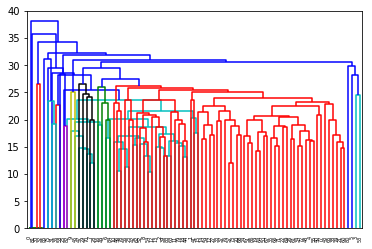

In [19]:
run()